# Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import re
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn

from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [2]:
device = torch.device("cuda:0")

# Load Data

In [42]:
file_path = '/kaggle/input/new-merged-7'
df = pd.read_csv(os.path.join(file_path, 'new_merged-dataset_simple_preprocessing.csv'))
df.head()

,sentence,emotion
0,"어, 청소 니가 대신 해 줘!",분노
1,둘 다 청소 하기 싫어. 귀찮아.,분노
2,둘 다 하기 싫어서 화내.,분노
3,그럼 방세는 어떡해.,분노
4,권태긴줄 알았는데 다른 사람이 생겼나보더라고.,슬픔


In [43]:
len(df)

128212

In [7]:
df['len'] =  df['sentence'].apply(lambda x: len(x.split(" ")))
max(df['len'].values)

142

In [44]:
df = df.drop_duplicates()
df = df.reset_index(drop=True)

In [45]:
len(df)

121133

### LabelEncoder

In [46]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
df['label'] = LE.fit_transform(df['emotion'])

labels = LE.classes_
print(len(labels), labels)

7 ['공포' '기쁨' '놀람' '분노' '슬픔' '중립' '혐오']


In [47]:
df['emotion'].value_counts()

emotion
중립    43211
분노    18950
슬픔    18511
놀람    11210
기쁨    10522
혐오     9741
공포     8988
Name: count, dtype: int64

In [48]:
import re
def preprocessing(text):
    text = re.sub(r"[^가-힣ㅏ-ㅣㄱ-ㅎA-Za-z0-9,!?]", " ", text)
    return text

In [49]:
df['sentence'] = df['sentence'].apply(preprocessing)

### Train / Test Split

In [50]:
from sklearn.model_selection import train_test_split

x = df['sentence']
y = df['label']

x_train_, x_test, y_train_, y_test = train_test_split(x, y, test_size=10000, random_state=42, shuffle=True, stratify=y)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_, y_train_, test_size=10000, random_state=42, shuffle=True, stratify=y_train_)

print(len(x_train), len(x_valid), len(x_test))

101133 10000 10000


### Re-arrange Data

In [51]:
def create_data_list(x, y):
  data_list = []
  for q, label in zip(x, y):
    data = []
    data.append(q)
    data.append(label)
    data_list.append(data)
  return data_list

In [52]:
train = create_data_list(x_train, y_train)
valid = create_data_list(x_valid, y_valid)
test = create_data_list(x_test, y_test)

# KoBERTTokenizer

In [16]:
MODEL_NAME = 'klue/roberta-small'
roberta_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=768)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

config.json:   0%|          | 0.00/545 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/752k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

### token length

In [17]:
from torch.utils.data import Dataset, DataLoader

In [18]:
class RobertaDataset(Dataset):
    def __init__(self, dataset, q_idx, label_idx, tokenizer, max_len):

      # self.sentences, self.labels = [], []

      # for i in dataset:
        # tokenized = tokenizer(i[q_idx], truncation=True, padding='max_length', max_length=max_len, return_tensors='pt')
        # if tokenized['attention_mask'].sum() > 10:
            # self.sentences.append(tokenized)
            # self.labels.append(torch.tensor(i[label_idx]))

        self.sentences = [tokenizer(i[q_idx], truncation=True, padding='max_length', max_length=max_len, return_tensors='pt') for i in dataset]
        self.labels = [torch.tensor(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i], self.labels[i])

    def __len__(self):
        return (len(self.labels))

In [18]:
max_len = 300

trainset = RobertaDataset(train, 0, 1, tokenizer, max_len)
validset = RobertaDataset(valid, 0, 1, tokenizer, max_len)
testset = RobertaDataset(test, 0, 1, tokenizer, max_len)

In [19]:
token_len_train = [d[0]['attention_mask'].sum().item() for d in trainset]
token_len_valid = [d[0]['attention_mask'].sum().item() for d in validset]
token_len_test = [d[0]['attention_mask'].sum().item() for d in testset]

In [20]:
print(min(token_len_train), max(token_len_train), len(token_len_train))
print(min(token_len_valid), max(token_len_valid), len(token_len_valid))
print(min(token_len_test), max(token_len_test), len(token_len_test))

3 213 101133
4 121 10000
3 154 10000


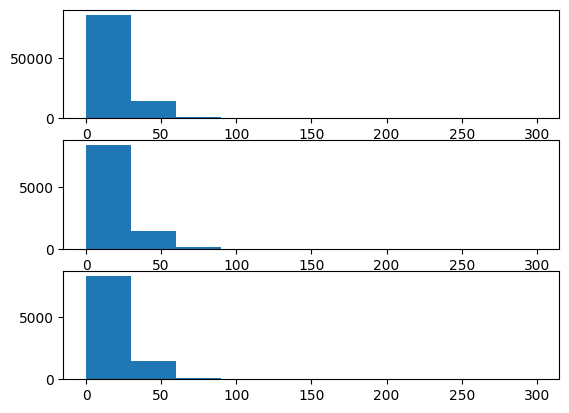

In [21]:
fig, ax = plt.subplots(3, 1)

ax[0].hist(token_len_train, range=[0, 300])
ax[1].hist(token_len_valid, range=[0, 300])
ax[2].hist(token_len_test, range=[0, 300])

plt.show()

In [53]:
max_len = 64

trainset = RobertaDataset(train, 0, 1, tokenizer, max_len)
validset = RobertaDataset(valid, 0, 1, tokenizer, max_len)

In [54]:
batch_size = 256

train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size)
valid_dataloader = torch.utils.data.DataLoader(validset, batch_size=batch_size)

# Model Training

In [55]:
# set params
num_classes = len(labels)
num_epochs = 50
hidden_size = 768

learning_rate = 5e-5

In [56]:
for i, (name, param) in enumerate(roberta_model.named_parameters()):

    if 'classifier' in name:
      print(i, name)
      print('END')
      break

    param.requires_grad = False

101 classifier.dense.weight
END


In [57]:
def calc_accuracy(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

##### Training

In [75]:
from IPython.display import clear_output

def loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch):

  figure, ax = plt.subplots(1, 2, figsize=(12, 5))

  ax[0].plot(train_loss_epoch)
  ax[0].plot(val_loss_epoch)
  ax[0].set_title('Loss-Epoch curve')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['train', 'val'], loc='upper right')

  ax[1].plot(train_acc_epoch)
  ax[1].plot(val_acc_epoch)
  ax[1].set_title('Model Accuracy')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['train', 'val'], loc='lower right')

  plt.show()

In [59]:
from torch.autograd import Variable

class RobertaClassifier(nn.Module):
    def __init__(self, base_model, num_classes, dr_rate, hidden_size):
        super().__init__()

        self.dr_rate = dr_rate
        self.roberta = base_model.roberta
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.roberta_classifier = base_model.classifier
        self.dense = nn.Linear(hidden_size, 384)
        # self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dr_rate)
        self.classifier = nn.Linear(384 , num_classes)
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):

        h_0 = Variable(torch.zeros(1, len(input_ids), hidden_size).cuda())
        c_0 = Variable(torch.zeros(1, len(input_ids), hidden_size).cuda())

        out = self.roberta(input_ids=input_ids, attention_mask=attention_mask)[0]
        out, (h, c) = self.lstm(out, (h_0, c_0))
        out = self.roberta_classifier(out)
        out = self.dense(out)
        # out = self.relu(out)
        out = self.dropout(out)
        out = self.classifier(out)
        # out = self.softmax(out)

        return out

In [60]:
model = RobertaClassifier(roberta_model, num_classes, 0.2, 768)

In [61]:
save_layers = []
for i, (name, param) in enumerate(model.named_parameters()):

    if param.requires_grad:
        save_layers.append(name)
        print(i, name)

101 lstm.weight_ih_l0
102 lstm.weight_hh_l0
103 lstm.bias_ih_l0
104 lstm.bias_hh_l0
105 roberta_classifier.dense.weight
106 roberta_classifier.dense.bias
107 roberta_classifier.out_proj.weight
108 roberta_classifier.out_proj.bias
109 dense.weight
110 dense.bias
111 classifier.weight
112 classifier.bias


In [ ]:
model

In [62]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # correct_bias=False
loss_fn = nn.CrossEntropyLoss()

In [63]:
from collections import OrderedDict
import pickle

def save_checkpoint(epoch, labels, model, optimizer, 
                    train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch,
                    model_path, filename, save_layers):
    
    model_dict = OrderedDict([(k, v) for k, v in model.state_dict().items() if k in save_layers])
    state = {
        'epoch': epoch,
        'state_dict': model_dict,
        'optimizer': optimizer.state_dict(),
        'label': labels
    }
    torch.save(state, os.path.join(model_path, f'{filename}.pt'))
    
    for_inference = {
        'state_dict': model_dict,
        'label': labels
    }
    torch.save(for_inference, os.path.join(model_path, f'{filename}_pretrained.pt'))

    config = {"train":{"acc":train_acc_epoch, "loss":train_loss_epoch},
          "valid":{"acc":val_acc_epoch, "loss":val_loss_epoch}}

    with open(os.path.join(model_path, f'{filename}.pickle'),'wb') as fw:
        pickle.dump(config, fw)

In [64]:
model_path = '/kaggle/working'

In [65]:
def load_dict(model, optimizer, dict_file):
    
    pretrained = torch.load(dict_file)
    
    epoch = pretrained['epoch']
    state_dict = pretrained['state_dict']
    opt_dict = pretrained['optimizer']
    labels = pretrained['label']
    
    model_dict = model.state_dict()
    model_dict.update(state_dict)
    model.load_state_dict(model_dict)
    
    optimizer.load_state_dict(opt_dict)
    
    return epoch, labels, model, optimizer

In [66]:
import pickle
def load_records(pkl_file):
    with open(pkl_file, 'rb') as f:
        records = pickle.load(f)
    return records['train'], records['valid']

In [67]:
os.listdir(file_path)

['new_merged-dataset_simple_preprocessing.csv',
 'roberta-small_115-epochs.pickle',
 'roberta-small_new_merged-dataset.pt',
 'roberta-small_epochs.pickle',
 'roberta-small_new_merged-dataset_115-epochs.pt']

In [68]:
pretrained = True
dict_file = os.path.join(file_path, 'roberta-small.pt')
pkl_file = os.path.join(file_path, 'roberta-small.pickle')

In [69]:
best_val_acc, best_val_loss = 0.0, 100.0

train_loss_epoch, val_loss_epoch = [], []
train_acc_epoch, val_acc_epoch = [], []
epoch_start = 1

model = model.to(device)

if pretrained:
    epoch_start, labels, model, optimizer = load_dict(model, optimizer, dict_file)
    train_epoch, valid_epoch = load_records(pkl_file)
    train_loss_epoch, train_acc_epoch = train_epoch['loss'], train_epoch['acc']
    val_loss_epoch, val_acc_epoch = valid_epoch['loss'], valid_epoch['acc']

epoch 148 train acc 0.7150508996212122 validation acc 0.71796875


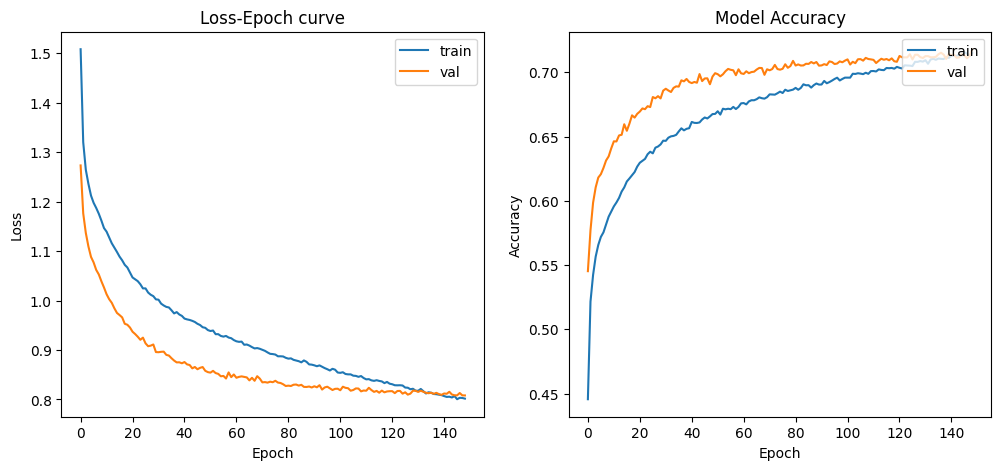

  0%|          | 0/396 [00:00<?, ?it/s]

epoch 149 train acc 0.7132487737956488 loss 0.8008771333279032


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 149 valid acc 0.71572265625 loss 0.8088873296976089


  0%|          | 0/396 [00:00<?, ?it/s]

epoch 150 train acc 0.7149226641414141 loss 0.8013064625738847


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 150 valid acc 0.7126953125 loss 0.8128787115216255


  0%|          | 0/396 [00:00<?, ?it/s]

epoch 151 train acc 0.7139491368006993 loss 0.7987532701456186


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 151 valid acc 0.71552734375 loss 0.8091256275773049


  0%|          | 0/396 [00:00<?, ?it/s]

epoch 152 train acc 0.7166587752525253 loss 0.7961543557619808


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 152 valid acc 0.7171875 loss 0.8100187003612518


  0%|          | 0/396 [00:00<?, ?it/s]

epoch 153 train acc 0.7183948863636364 loss 0.7933527111931883


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 153 valid acc 0.71337890625 loss 0.8155479818582535


  0%|          | 0/396 [00:00<?, ?it/s]

epoch 154 train acc 0.7169645675505051 loss 0.7958533954665516


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 154 valid acc 0.7140625 loss 0.8102614969015122


  0%|          | 0/396 [00:00<?, ?it/s]

epoch 155 train acc 0.7186316287878788 loss 0.7884445345085679


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 155 valid acc 0.71357421875 loss 0.8121329642832279


  0%|          | 0/396 [00:00<?, ?it/s]

epoch 156 train acc 0.7189966066919192 loss 0.7890385187635518


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 156 valid acc 0.71484375 loss 0.8094702824950218


  0%|          | 0/396 [00:00<?, ?it/s]

epoch 157 train acc 0.718621764520202 loss 0.7906958327600451


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 157 valid acc 0.71376953125 loss 0.8134261161088944


  0%|          | 0/396 [00:00<?, ?it/s]

epoch 158 train acc 0.7176353377525253 loss 0.7904219357579043


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 158 valid acc 0.71484375 loss 0.810963848233223


  0%|          | 0/396 [00:00<?, ?it/s]

epoch 159 train acc 0.7178720801767676 loss 0.7888186077653158


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 159 valid acc 0.7134765625 loss 0.8114607587456704


  0%|          | 0/396 [00:00<?, ?it/s]

epoch 160 train acc 0.7193350269522144 loss 0.7866859217033242


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 160 valid acc 0.715234375 loss 0.8111837804317474


  0%|          | 0/396 [00:00<?, ?it/s]

epoch 161 train acc 0.7197857481060606 loss 0.7846682910816838


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 161 valid acc 0.71533203125 loss 0.8103577598929406


  0%|          | 0/396 [00:00<?, ?it/s]

epoch 162 train acc 0.7211371527777778 loss 0.7839005689578827


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 162 valid acc 0.715234375 loss 0.8100319243967533


  0%|          | 0/396 [00:00<?, ?it/s]

epoch 163 train acc 0.7180792297979798 loss 0.7846722870011522


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 163 valid acc 0.7150390625 loss 0.8102072715759278


  0%|          | 0/396 [00:00<?, ?it/s]

epoch 164 train acc 0.7201803188131313 loss 0.7837071992983722


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 164 valid acc 0.71533203125 loss 0.809328019618988


  0%|          | 0/396 [00:00<?, ?it/s]

epoch 165 train acc 0.7217684659090909 loss 0.7821790817560572


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 165 valid acc 0.716015625 loss 0.8113825485110283


In [70]:
for e in range(epoch_start+1, num_epochs+epoch_start+1):
    train_acc, train_loss = 0.0, 0.0
    val_acc, val_loss = 0.0, 0.0
    model.train()
    for batch_id, (sentence, label) in enumerate(tqdm.notebook.tqdm(train_dataloader)):
        optimizer.zero_grad()

        attention_mask = sentence['attention_mask'].to(device)
        input_ids = sentence['input_ids'].squeeze(1).to(device)

        label = label.to(device)

        out = model(input_ids, attention_mask)
        loss = loss_fn(out, label)

        train_loss += loss.item()
        loss.backward()

        optimizer.step()

        train_acc += calc_accuracy(out, label)

    tot_train_acc = train_acc / (batch_id+1)
    mean_train_loss = train_loss / (batch_id+1)
    train_loss_epoch.append(mean_train_loss)
    train_acc_epoch.append(tot_train_acc)
    print("epoch {} train acc {} loss {}".format(e, tot_train_acc, mean_train_loss))

    model.eval()
    for batch_id, (sentence, label) in enumerate(tqdm.notebook.tqdm(valid_dataloader)):

        attention_mask = sentence['attention_mask'].to(device)
        input_ids = sentence['input_ids'].squeeze(1).to(device)

        label = label.long().to(device)

        out = model(input_ids, attention_mask)
        loss = loss_fn(out, label)
        val_loss += loss.item()
        val_acc += calc_accuracy(out, label)
    tot_acc = val_acc / (batch_id+1)
    mean_val_loss = val_loss / (batch_id+1)
    val_loss_epoch.append(mean_val_loss)
    val_acc_epoch.append(tot_acc)
    print("epoch {} valid acc {} loss {}".format(e, tot_acc, mean_val_loss))
    if best_val_loss > mean_val_loss:
      clear_output(wait=True)
      print("epoch {} train acc {} validation acc {}".format(e, tot_train_acc, tot_acc))
      loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)
      best_val_loss = mean_val_loss
      save_checkpoint(e, labels, model, optimizer, 
                      train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch,
                      model_path, 'roberta-small', save_layers)

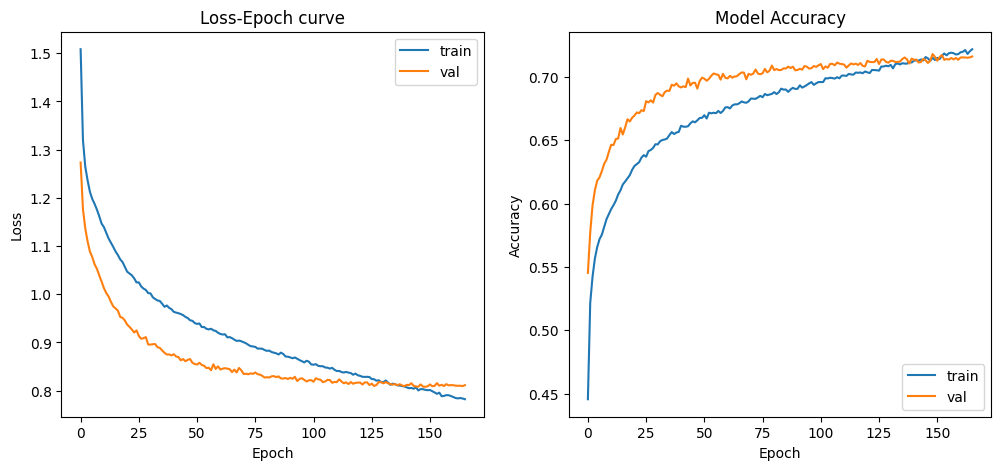

In [76]:
loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)

# Evaluation

In [83]:
max_len = 64
dr_rate = 0.4

In [84]:
os.listdir('/kaggle/working')

['roberta-small_new_merged-dataset.pt',
 'roberta-small_epochs.pickle',
 '.virtual_documents']

In [85]:
best_model = torch.load(os.path.join(model_path, 'roberta-small_new_merged-dataset.pt'))

In [94]:
pretrained_dict = best_model['state_dict']

model = RobertaClassifier(roberta_model, num_classes, dr_rate, hidden_size)
model_dict = model.state_dict()

model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

model = model.to(device)

In [92]:
def inference(sentence, label, model):

  attention_mask = sentence['attention_mask'].to(device)
  input_ids = sentence['input_ids'].squeeze(1).to(device)

  out = model(input_ids, attention_mask)
  acc = calc_accuracy(out, label)

  return acc

In [90]:
def calc_accuracy(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return max_indices, train_acc

In [95]:
pred_dict = {"sentence":[], "label":[], "pred":[]}
i = 0
for data in test:
  x = tokenizer(data[0], truncation=True, padding='max_length', max_length=64, return_tensors='pt')
  pred, acc = inference(x, data[1], model)
  pred_dict['sentence'].append(data[0])
  pred_dict['label'].append(labels[data[1]])
  pred_dict['pred'].append(labels[pred])
  i += 1
  if i % 1000 == 0:
    print(i, "done")

1000 done
2000 done
3000 done
4000 done
5000 done
6000 done
7000 done
8000 done
9000 done
10000 done


In [97]:
df_pred = pd.DataFrame(pred_dict)
df_pred.head()

,sentence,label,pred
0,자꾸 바쁘다고 나한테만 연락해!,분노,분노
1,"너 교실로 안 돌아가면, 나 이 학교 뜬다 선생 때려 칠 거야 선생님도 따라해...",중립,중립
2,응 자주 그래 속상해,분노,분노
3,노트북이 오늘 도착했어,기쁨,기쁨
4,"지금 살고 있는 하숙집은 마음에 들어요? 네, 방도 깨끗하고 하숙집 아주머니도 아주...",중립,중립


In [98]:
df_pred.to_csv('/kaggle/working/roberta-small_prediction.csv', index=False, header=True)

In [96]:
correct = 0
for i in range(len(pred_dict['label'])):
  if pred_dict['label'][i] == pred_dict['pred'][i]:
    correct += 1
correct / len(pred_dict['label'])

0.7052